In [1]:
# modified from https://github.com/SherlockLiao/Deep-Dream/blob/master/show_image.ipynb
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from deepDream import dream
import torch.nn as nn
import spectroUtils as sUtils
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import math
from torch.autograd import Variable
from network import *

import matplotlib.pyplot as plt

('track', 'tags')
('album', 'tags')
('artist', 'tags')
('track', 'genres')
('track', 'genres_all')


/home/iaakhter/cs532l/DreamingInMusic/utils.py:218: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  'category', categories=SUBSETS, ordered=True)


# Experiments with Original Phase

In [2]:
#Original hip-hopaudio
trackId = 2
minAmp = -80.0
maxAmp = 1.9073486e-06
audioDirectory = "data/fma_small/"
audioFilename = audioDirectory + "000/000002.mp3"
x, sr = librosa.load(audioFilename, sr=None, mono=True, duration = 10, offset = 0)
start, end = 0, 30
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

scaledSpectro [[113 166 177 ... 207 198 195]
 [103 157 143 ... 172 149 171]
 [121 175 177 ... 180 181 173]
 ...
 [ 18  37  70 ...  56  60 124]
 [ 10  65  45 ...  63  65 124]
 [  0  66  59 ...  65  46 124]]


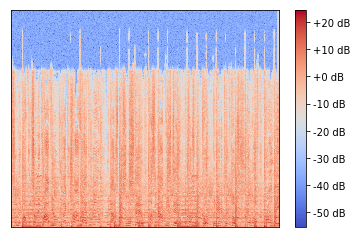

In [3]:
#scaledSpectro, phase, origSpectroSize = sUtils.loadSpectro(trackId, spectroSize, minAmp, maxAmp)
#scaledSpectro = scaledSpectro.data.numpy()
spectro = librosa.core.stft(x)
origMag, origPhase = librosa.core.magphase(spectro)
origSpectroSize = spectro.shape
spectroSize = (512, 512)
scaledSpectro = sUtils.scaleSpectro(librosa.power_to_db(np.abs(spectro)), spectroSize, minAmp, maxAmp)
#scaledPhase = sUtils.scaleSpectro(np.angle(spectro), spectroSize, -math.pi, math.pi)

print("scaledSpectro", scaledSpectro)
#print ("scaledPhase", scaledPhase)
#scaledSpectro = scaledSpectro.data.numpy()
#scaledPhase = scaledPhase.data.numpy()

plt.figure()
librosa.display.specshow(librosa.power_to_db(np.abs(spectro)))
plt.colorbar(format='%+2.0f dB')
plt.show()

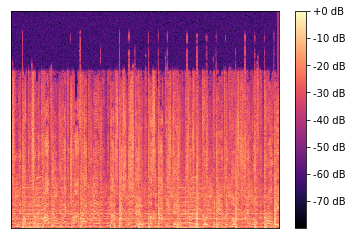

In [4]:
# Get the power spectrogram from decibal version
'''backToSpectro = sUtils.unscaleSpectro(scaledSpectro[0], origSpectroSize, minAmp, maxAmp)
# Multiply power spectrogram with phase to get original complex spectrogram
backToSpectro = backToSpectro*phase

# Revert complex spectrogram to audio
n = len(x)
y_hat = librosa.istft(backToSpectro, length = n)
ipd.Audio(data=y_hat[start*sr:end*sr], rate=sr)'''
backToSpectro = librosa.power_to_db(sUtils.unscaleSpectro(scaledSpectro, origSpectroSize, minAmp, maxAmp))
plt.figure()
librosa.display.specshow(backToSpectro)
plt.colorbar(format='%+2.0f dB')
plt.show()

In [5]:
backToSpectro = librosa.core.db_to_power(backToSpectro)
'''backToPhase = sUtils.unscaleSpectro(scaledPhase, origSpectroSize, -math.pi, math.pi)
invStft = np.zeros(backToSpectro.shape, dtype=np.complex_)
for i in range(invStft.shape[0]):
    for j in range(invStft.shape[1]):
        invStft[i,j] = complex(backToSpectro[i,j]*math.cos(backToPhase[i,j]), backToSpectro[i,j]*math.sin(backToPhase[i,j]))'''
n = len(x)
y_hat = librosa.istft(backToSpectro*origPhase, length = n)
ipd.Audio(data=y_hat[start*sr:end*sr], rate=sr)

In [6]:
librosa.output.write_wav('scaledExample.wav', y_hat, sr)

In [7]:
scaledSpectro = np.expand_dims(np.expand_dims(scaledSpectro, 0),0).astype(np.float32)
#scaledPhase = np.expand_dims(scaledPhase, 0).astype(np.float32)

In [8]:
modelMag = resnet18(channel=1, num_classes=4).cuda()
#modelMag = torch.nn.DataParallel(modelMag).cuda()
#modelPhase = models.__dict__['resnet18']()
#modelPhase = torch.nn.DataParallel(modelPhase).cuda()

1


In [9]:
checkpoint = torch.load('new_model/checkpoints/model_best.pth.tar')
modelMag.load_state_dict(checkpoint['state_dict'])

'''checkpoint_path = 'resnet18/checkpoints/checkpoint_mag_512.pth.tar'
print("=> loading checkpoint '{}'".format(checkpoint_path))
checkpoint = torch.load(checkpoint_path)
start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
modelMag.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch: {}) (best_acc: {})"
        .format(checkpoint_path, checkpoint['epoch'], checkpoint['best_prec1']))

checkpoint_path = 'resnet18/checkpoints/checkpoint_phase_512.pth.tar'
print("=> loading checkpoint '{}'".format(checkpoint_path))
checkpoint = torch.load(checkpoint_path)
start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
modelPhase.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch: {}) (best_acc: {})"
        .format(checkpoint_path, checkpoint['epoch'], checkpoint['best_prec1']))'''

modelMag = nn.Sequential(*list(modelMag.children())[:-3])
#modelPhase = nn.Sequential(*list(modelPhase.children())[:-3])

In [10]:
print ("scaledSpectro.shape", scaledSpectro.shape)
dreamSpectro = dream(modelMag, scaledSpectro)
dreamSpectro = dreamSpectro[0,0,:]
print ("dreamSpectro")
print (dreamSpectro.shape)

scaledSpectro.shape (1, 1, 512, 512)
model after removing 7
(1, 1, 95, 95)


/home/iaakhter/.conda/envs/mypy35/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


ratio 0.06344487
learning_rate_use 6.3046864830955025
imgBefore [[[[1.13170746e+02 1.79777634e+02 1.87964951e+02 ... 1.89404297e+02
    2.00400177e+02 1.95089630e+02]
   [1.10113625e+02 1.85600327e+02 1.88253647e+02 ... 2.04233521e+02
    2.04646347e+02 1.95696304e+02]
   [1.02646690e+02 1.81727936e+02 1.92260818e+02 ... 1.99786880e+02
    2.07240463e+02 2.04915543e+02]
   ...
   [2.45125580e+01 5.89260826e+01 5.70567131e+01 ... 5.87772179e+01
    6.00706215e+01 1.24116928e+02]
   [2.11743908e+01 5.89274178e+01 5.77288513e+01 ... 5.80638962e+01
    5.97853127e+01 1.23968620e+02]
   [1.16166554e-01 5.96729431e+01 5.96669846e+01 ... 5.64326706e+01
    5.76248436e+01 1.23957535e+02]]]]
imgAfter (1, 1, 95, 95)
ratio 0.063168235
learning_rate_use 6.332296592110421
imgBefore [[[[1.1266128e+02 1.7833215e+02 1.8642999e+02 ... 1.9052892e+02
    2.0021652e+02 1.9474506e+02]
   [1.0871154e+02 1.8298964e+02 1.8739238e+02 ... 2.0536024e+02
    2.0470683e+02 1.9492499e+02]
   [1.0151572e+02 1.811732

ratio 0.059784614
learning_rate_use 6.690684713842144
imgBefore [[[[112.63606   178.06355   186.67744   ... 188.68002   197.27773
    194.06311  ]
   [109.677185  181.24825   184.86513   ... 205.32695   205.69537
    194.33693  ]
   [ 97.69797   180.67618   194.56633   ... 207.22044   209.39963
    202.66347  ]
   ...
   [ 24.37118    58.17259    57.648567  ...  59.52165    61.587704
    125.02979  ]
   [ 20.50008    58.5236     59.792656  ...  59.60114    61.29709
    124.27707  ]
   [  1.7575715  60.56328    60.679996  ...  57.289864   56.008957
    123.1018   ]]]]
imgAfter (1, 1, 95, 95)
ratio 0.058009874
learning_rate_use 6.895377836510327
imgBefore [[[[112.37108   177.78983   187.22946   ... 188.7743    196.9506
    194.31735  ]
   [108.90381   180.79797   185.57333   ... 206.31302   206.37497
    195.05334  ]
   [ 97.50552   180.16397   194.39153   ... 208.15039   209.45364
    202.19698  ]
   ...
   [ 24.584414   58.53676    57.77427   ...  59.917107   61.448715
    125.25521  ]

ratio 0.064437404
learning_rate_use 6.207574692073045
imgBefore [[[[111.442085  171.76059   178.31573   ... 210.3068    208.34462
    197.32375  ]
   [107.699     179.62494   178.925     ... 211.14406   194.3268
    176.25685  ]
   [ 95.47312   195.84076   193.99136   ... 212.94136   202.50598
    199.29958  ]
   ...
   [ 30.004103   59.06699    61.698067  ...  62.5903     61.069824
    127.49719  ]
   [ 20.436745   58.904827   63.55164   ...  59.345535   60.40861
    128.5118   ]
   [  5.3247476  63.322372   64.215034  ...  51.575233   62.305077
    126.715675 ]]]]
imgAfter (1, 1, 186, 186)
ratio 0.06256017
learning_rate_use 6.393844427157197
imgBefore [[[[111.32656   171.61183   178.14413   ... 210.37285   208.67232
    197.49875  ]
   [107.364334  179.69676   178.92107   ... 211.24585   195.153
    176.28896  ]
   [ 95.33749   195.75249   194.04543   ... 213.1538    202.66393
    199.5043   ]
   ...
   [ 29.943645   59.018074   61.710052  ...  62.594185   61.08157
    127.54813  ]
 

imgAfter (1, 1, 261, 261)
ratio 0.060914606
learning_rate_use 6.5665696162586755
imgBefore [[[[112.71738   174.86885   178.18585   ... 210.83885   206.93819
    198.98094  ]
   [111.127     173.94565   173.30911   ... 187.75708   183.82724
    166.89417  ]
   [101.68279   196.31377   178.83466   ... 210.95164   206.18889
    194.92415  ]
   ...
   [ 31.08089    61.90379    61.702854  ...  62.084553   59.130352
    126.35319  ]
   [ 13.90317    61.492554   57.69424   ...  59.550007   62.690903
    126.96548  ]
   [  5.4891634  65.98707    66.4361    ...  69.78534    60.79565
    127.051895 ]]]]
imgAfter (1, 1, 261, 261)
ratio 0.06119117
learning_rate_use 6.536890711486995
imgBefore [[[[113.36573  174.57831  178.64363  ... 210.84663  207.8845
    199.74467 ]
   [110.70534  173.80957  173.23108  ... 187.18877  183.0176
    166.92459 ]
   [101.59853  195.47212  178.66405  ... 209.78658  205.72067
    194.61652 ]
   ...
   [ 30.786253  61.711216  61.431034 ...  62.42737   58.27884
    126.5

ratio 0.061308887
learning_rate_use 6.524339626986612
imgBefore [[[[114.02985  172.75485  175.62347  ... 202.65877  201.74438
    199.1986  ]
   [108.75241  160.6035   168.02151  ... 171.38614  165.87395
    173.70546 ]
   [117.3753   187.37195  186.5117   ... 196.3404   191.71402
    155.84694 ]
   ...
   [  9.674643  60.55482   69.4848   ...  62.864555  65.046104
    128.97275 ]
   [ 21.59082   62.322777  70.62197  ...  63.51837   67.08022
    127.780876]
   [  8.747832  72.02301   63.255455 ...  70.660065  57.77981
    128.54457 ]]]]
imgAfter (1, 1, 366, 366)
ratio 0.062662445
learning_rate_use 6.383408753745805
imgBefore [[[[114.7699   172.3337   174.98575  ... 201.56792  202.09827
    199.42316 ]
   [108.62704  159.63734  167.47787  ... 170.50047  165.96869
    173.8464  ]
   [118.49958  187.24593  186.70764  ... 196.45973  191.76382
    156.06488 ]
   ...
   [  9.434045  60.892616  69.71917  ...  62.4546    65.06082
    128.95515 ]
   [ 21.345604  62.332394  70.817345 ...  63.525

ratio 0.061528094
learning_rate_use 6.501095243844241
imgBefore [[[[116.47413  172.1079   175.34497  ... 197.7775   198.0406
    198.86084 ]
   [109.87146  161.77817  168.8184   ... 167.4525   164.63298
    174.18564 ]
   [117.249084 187.2532   187.59578  ... 194.21712  191.93042
    156.38963 ]
   ...
   [ 10.134318  61.134636  70.43647  ...  62.42943   66.792305
    128.74113 ]
   [ 20.886234  63.43742   71.849625 ...  64.705215  68.22575
    127.1826  ]
   [  9.912106  73.31484   64.72014  ...  69.61066   57.491257
    128.6541  ]]]]
imgAfter (1, 1, 366, 366)
ratio 0.05681039
learning_rate_use 7.0409655445473405
imgBefore [[[[116.296974 172.0091   175.47256  ... 198.21657  198.06952
    198.56892 ]
   [109.18556  161.27338  168.74847  ... 167.02591  164.27481
    173.8728  ]
   [116.973885 186.93495  187.57706  ... 193.91782  192.2099
    156.52008 ]
   ...
   [ 10.082434  61.38302   70.7963   ...  62.40472   66.605804
    128.02791 ]
   [ 21.324657  63.609276  72.265564 ...  64.975

ratio 0.05827412
learning_rate_use 6.86411050678777
imgBefore [[[[115.62685  166.42755  178.94057  ... 200.95679  193.9626
    197.63852 ]
   [101.96039  156.31702  145.12657  ... 166.54393  143.2188
    172.01718 ]
   [118.75544  174.28656  179.02126  ... 176.99847  181.2877
    175.45244 ]
   ...
   [ 25.409538  44.208626  77.86565  ...  63.28147   67.68961
    127.90341 ]
   [ 18.782356  73.56092   54.23682  ...  70.52889   71.84191
    127.86422 ]
   [ 10.518178  73.93766   68.79509  ...  69.64049   51.889404
    130.68605 ]]]]
imgAfter (1, 1, 512, 512)
ratio 0.060647268
learning_rate_use 6.5955155803695575
imgBefore [[[[116.011284 166.41498  178.70251  ... 200.67851  193.14519
    197.2667  ]
   [101.62069  156.7156   145.3823   ... 166.2968   142.79976
    171.79839 ]
   [118.935    174.68098  179.49039  ... 177.15906  181.31082
    175.16058 ]
   ...
   [ 25.490894  43.905876  77.81188  ...  63.43192   67.561745
    127.7748  ]
   [ 18.197193  73.51323   54.24307  ...  70.49856 

In [11]:
'''dreamPhase = dream(modelPhase, scaledPhase)
dreamPhase = dreamPhase[0,:]
print ("dreamPhase")
print (dreamPhase)'''

'dreamPhase = dream(modelPhase, scaledPhase)\ndreamPhase = dreamPhase[0,:]\nprint ("dreamPhase")\nprint (dreamPhase)'

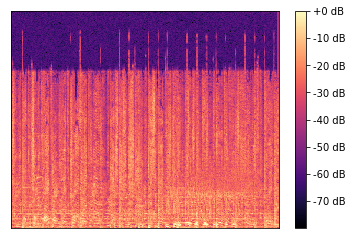

In [12]:
#Convert it back to 
'''backToSpectro = sUtils.unscaleSpectro(dreamSpectro, origSpectroSize, minAmp, maxAmp)
# Multiply power spectrogram with phase to get original complex spectrogram
backToSpectro = backToSpectro*phase

# Revert complex spectrogram to audio
n = len(x)
y_hat = librosa.istft(backToSpectro, length = n)
ipd.Audio(data=y_hat[start*sr:end*sr], rate=sr)'''
backToSpectro = librosa.power_to_db(sUtils.unscaleSpectro(dreamSpectro, origSpectroSize, minAmp, maxAmp))
plt.figure()
librosa.display.specshow(backToSpectro)
plt.colorbar(format='%+2.0f dB')
plt.show()

In [13]:
backToSpectro = librosa.core.db_to_power(backToSpectro)
'''backToPhase = sUtils.unscaleSpectro(dreamPhase, origSpectroSize, -math.pi, math.pi)
invStft = np.zeros(backToSpectro.shape, dtype=np.complex_)
for i in range(invStft.shape[0]):
    for j in range(invStft.shape[1]):
        invStft[i,j] = complex(backToSpectro[i,j]*math.cos(backToPhase[i,j]), backToSpectro[i,j]*math.sin(backToPhase[i,j]))'''
n = len(x)
y_hat = librosa.istft(backToSpectro*origPhase, length = n)
ipd.Audio(data=y_hat[start*sr:end*sr], rate=sr)

In [14]:
librosa.output.write_wav('dreamExample.wav', y_hat, sr)

## Noise Dream

In [15]:
noiseSpectro = np.random.random(spectroSize)*255
noisePhase = np.random.random(spectroSize)*2*math.pi - math.pi
backToNoiseSpectro = librosa.core.db_to_power(sUtils.unscaleSpectro(noiseSpectro, origSpectroSize, minAmp, maxAmp))
#backToNoisePhase = sUtils.unscaleSpectro(noisePhase, origSpectroSize, -math.pi, math.pi)
#invStftNoise = np.zeros(backToNoiseSpectro.shape, dtype=np.complex_)
#for i in range(invStftNoise.shape[0]):
#    for j in range(invStftNoise.shape[1]):
#        invStftNoise[i,j] = complex(backToNoiseSpectro[i,j]*math.cos(backToNoisePhase[i,j]), backToNoiseSpectro[i,j]*math.sin(backToNoisePhase[i,j]))
n = len(x)
y_hat = librosa.istft(backToNoiseSpectro*origPhase, length = n)
ipd.Audio(data=y_hat[start*sr:end*sr], rate=sr)


In [16]:
noiseSpectro = np.expand_dims(np.expand_dims(noiseSpectro, 0),0).astype(np.float32)
'''noisePhase = np.expand_dims(noisePhase, 0).astype(np.float32)'''

'noisePhase = np.expand_dims(noisePhase, 0).astype(np.float32)'

In [17]:
modelMag = resnet18(channel=1, num_classes=4).cuda()
'''modelMag = models.__dict__['resnet18']()
modelMag = torch.nn.DataParallel(modelMag).cuda()
modelPhase = models.__dict__['resnet18']()
modelPhase = torch.nn.DataParallel(modelPhase).cuda()'''

1


"modelMag = models.__dict__['resnet18']()\nmodelMag = torch.nn.DataParallel(modelMag).cuda()\nmodelPhase = models.__dict__['resnet18']()\nmodelPhase = torch.nn.DataParallel(modelPhase).cuda()"

In [18]:
checkpoint = torch.load('new_model/checkpoints/model_best.pth.tar')
modelMag.load_state_dict(checkpoint['state_dict'])
'''checkpoint_path = 'resnet18/checkpoints/checkpoint_mag_512.pth.tar'
print("=> loading checkpoint '{}'".format(checkpoint_path))
checkpoint = torch.load(checkpoint_path)
start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
modelMag.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch: {}) (best_acc: {})"
        .format(checkpoint_path, checkpoint['epoch'], checkpoint['best_prec1']))

checkpoint_path = 'resnet18/checkpoints/checkpoint_phase_512.pth.tar'
print("=> loading checkpoint '{}'".format(checkpoint_path))
checkpoint = torch.load(checkpoint_path)
start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
modelPhase.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch: {}) (best_acc: {})"
        .format(checkpoint_path, checkpoint['epoch'], checkpoint['best_prec1']))'''

modelMag = nn.Sequential(*list(modelMag.children())[:-3])
#modelPhase = nn.Sequential(*list(modelPhase.children())[:-3])

In [19]:
print ("noiseSpectro.shape", noiseSpectro.shape)
dreamNoiseSpectro = dream(modelMag, noiseSpectro)
dreamNoiseSpectro = dreamNoiseSpectro[0,0,:]
print ("dreamNoiseSpectro")
print (dreamNoiseSpectro)

noiseSpectro.shape (1, 1, 512, 512)
model after removing 7
(1, 1, 95, 95)
ratio 0.105472386
learning_rate_use 3.7924618529295584
imgBefore [[[[102.43259  137.83124  160.54387  ... 133.03159  135.55945
    191.10329 ]
   [116.61502  127.887886 124.103096 ... 125.2442   130.49187
    137.5502  ]
   [103.2323   135.25462  130.60208  ... 132.03642  135.66833
    130.25772 ]
   ...
   [136.10431  132.52841  130.95166  ... 125.47288  141.16986
    118.07697 ]
   [166.16037  125.87247  118.44442  ... 125.28466  126.27037
    114.89255 ]
   [ 37.299637 126.98004  103.993835 ... 131.49576  157.38396
     57.634857]]]]
imgAfter (1, 1, 95, 95)
ratio 0.11538557
learning_rate_use 3.4666379970696317
imgBefore [[[[101.787704 137.43172  160.57591  ... 132.54578  135.05754
    191.16765 ]
   [116.67227  128.31357  124.60727  ... 125.02917  129.48285
    137.34088 ]
   [103.85436  136.13417  130.52725  ... 131.39188  134.99617
    130.28119 ]
   ...
   [136.2943   132.28026  130.6051   ... 124.78266  14

/home/iaakhter/.conda/envs/mypy35/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


ratio 0.11580032
learning_rate_use 3.4542218552846475
imgBefore [[[[101.737206 136.95271  161.3249   ... 135.90039  135.02682
    192.53246 ]
   [113.80703  130.78847  125.29513  ... 123.03645  127.95586
    135.53424 ]
   [105.62702  139.15497  133.58002  ... 130.62988  137.59744
    130.02222 ]
   ...
   [136.14162  131.20586  132.0728   ... 125.79694  141.00752
    117.559875]
   [165.85924  127.2667   118.899574 ... 122.29321  126.99259
    112.56676 ]
   [ 39.081337 128.30899  103.65317  ... 131.62447  157.38791
     59.214573]]]]
imgAfter (1, 1, 95, 95)
ratio 0.1136044
learning_rate_use 3.5209904901216733
imgBefore [[[[103.323845 136.79149  161.0009   ... 134.755    133.8643
    191.96689 ]
   [112.92945  128.75072  124.63774  ... 122.49028  126.35683
    135.24208 ]
   [105.45254  138.0189   133.16917  ... 130.29715  136.98976
    129.8935  ]
   ...
   [136.26228  131.60666  133.12871  ... 124.46786  139.63284
    116.77394 ]
   [164.99611  127.05763  120.16007  ... 122.18364  1

ratio 0.113438204
learning_rate_use 3.5261489175535283
imgBefore [[[[102.602356 115.195915 162.2069   ... 145.21312  124.68852
    191.4717  ]
   [108.954575 121.31777  118.38011  ... 131.10446  123.97895
    141.67351 ]
   [126.48022  150.98431  129.17422  ... 109.894035 139.83804
    123.584435]
   ...
   [153.9339   128.4367   125.53899  ... 133.65128  127.2001
    122.16274 ]
   [172.87575  136.1917   114.473915 ... 110.698395 127.33722
    109.87001 ]
   [ 40.664494 132.082    120.53817  ... 163.91801  153.21735
     58.538017]]]]
imgAfter (1, 1, 133, 133)
ratio 0.10817419
learning_rate_use 3.6977397314148037
imgBefore [[[[102.80865  114.92636  161.84172  ... 144.4966   124.8143
    191.85364 ]
   [109.10949  121.18518  118.1373   ... 130.18893  124.07736
    142.33987 ]
   [126.0649   150.38068  129.42847  ... 109.908806 139.57541
    122.72438 ]
   ...
   [154.33687  129.2972   125.37327  ... 133.27155  126.965515
    122.010864]
   [172.78119  136.43529  114.28924  ... 110.7262

ratio 0.10805866
learning_rate_use 3.7016930940549893
imgBefore [[[[102.820045 120.07951  112.84894  ... 119.643425 131.30096
    188.84293 ]
   [ 91.395294 123.16527   95.90356  ... 150.28175   98.98435
    115.832146]
   [138.5689   152.97124  113.60624  ... 140.38412  133.00986
    181.85555 ]
   ...
   [183.7052   131.05394  110.2525   ... 140.56714  132.22276
    112.0865  ]
   [168.39809  167.4541   115.647156 ... 110.49948  133.96408
    107.77109 ]
   [ 40.871536 137.31503  123.21798  ... 137.39333  163.60873
     57.810757]]]]
imgAfter (1, 1, 186, 186)
ratio 0.11102421
learning_rate_use 3.6028178528256745
imgBefore [[[[103.75847  120.28446  112.54918  ... 119.44361  131.15698
    189.09813 ]
   [ 91.33801  123.12874   96.05131  ... 150.46652   98.51747
    115.8849  ]
   [137.73401  152.7501   113.52412  ... 140.22508  133.1248
    181.68428 ]
   ...
   [183.58192  131.30722  110.126785 ... 140.69014  132.36667
    111.62097 ]
   [168.53549  167.94884  115.989235 ... 110.49842

ratio 0.09384542
learning_rate_use 4.262328430794621
imgBefore [[[[105.00929  154.72699   67.36726  ... 194.40665   86.431435
    187.8329  ]
   [121.35595  138.0777    77.28813  ... 135.8562   112.03281
     59.342506]
   [ 46.954666 152.13972  115.243355 ...  83.265656  53.348892
    198.27048 ]
   ...
   [138.48471  163.8083   180.00081  ... 115.10145  130.01126
    161.57388 ]
   [192.345    187.91115  122.998055 ... 109.17069  160.60356
     75.259544]
   [ 42.266014 124.77209  154.23029  ... 223.50809  121.79313
     59.45794 ]]]]
imgAfter (1, 1, 261, 261)
ratio 0.09381233
learning_rate_use 4.263831773073393
imgBefore [[[[104.86774  154.76213   67.70482  ... 194.21906   86.240555
    187.86096 ]
   [121.3543   138.2945    76.945465 ... 135.79784  111.93964
     59.1448  ]
   [ 46.868683 151.36418  115.372154 ...  83.31557   52.714436
    198.23447 ]
   ...
   [138.21046  163.71333  179.7308   ... 115.53885  129.93692
    161.46677 ]
   [192.44641  187.63593  122.987206 ... 109.22

ratio 0.079691745
learning_rate_use 5.019340438451783
imgBefore [[[[104.92375  223.40182   55.593166 ...  76.183395  93.805664
    185.1509  ]
   [160.66457  132.9327   139.65588  ...  76.75828  114.9819
     55.926056]
   [ 62.867153  95.48898  205.01451  ... 144.0904   113.433525
     56.488045]
   ...
   [179.98079  198.35371  207.55975  ... 203.0628   161.41151
     61.862995]
   [199.64409  201.33356  131.99336  ... 157.02277  138.08699
     83.02907 ]
   [ 41.92476  105.83075  148.5525   ... 211.89903   61.28041
     59.94696 ]]]]
imgAfter (1, 1, 366, 366)
ratio 0.079962425
learning_rate_use 5.002349545184547
imgBefore [[[[104.80306  222.58887   54.537594 ...  76.15497   93.79102
    185.54901 ]
   [160.81244  132.6922   138.69037  ...  76.69084  115.228424
     55.896496]
   [ 63.07316   95.6398   203.99132  ... 144.4345   113.588356
     56.564884]
   ...
   [179.49991  198.45262  207.47444  ... 203.08104  161.35287
     61.76688 ]
   [200.24844  201.72021  131.9434   ... 157.0

ratio 0.0634905
learning_rate_use 6.300154889643916
imgBefore [[[[103.92319  240.41339  191.41586  ...  78.32588   98.05433
    181.73747 ]
   [ 99.98434  110.08712  234.91685  ...  29.783508 153.92162
     18.883999]
   [246.2681   115.623924  38.729015 ... 129.94415  126.31066
    103.230995]
   ...
   [214.34607  210.20508   71.1703   ... 196.50233  170.8647
     43.41825 ]
   [194.0252   249.02928  209.19688  ... 242.69028   21.463308
    107.54689 ]
   [ 42.103153  52.05189  185.52417  ...  36.612587  74.07903
     56.795532]]]]
imgAfter (1, 1, 512, 512)
ratio 0.06283491
learning_rate_use 6.365887900944311
imgBefore [[[[103.9464   240.91824  191.8101   ...  78.49196   97.89081
    181.94128 ]
   [ 99.652145 110.95247  235.44669  ...  30.663248 154.32709
     19.034409]
   [245.83606  115.65839   39.223297 ... 129.66562  126.307396
    102.895325]
   ...
   [214.11995  210.1292    70.53626  ... 196.76338  170.7028
     43.28238 ]
   [193.8957   249.1618   209.72964  ... 242.77155  

ratio 0.06311564
learning_rate_use 6.3375732330976895
imgBefore [[[[103.11881  240.22852  189.48254  ...  77.12234   95.33293
    179.85371 ]
   [ 99.5012   110.2634   234.98383  ...  28.73397  153.49608
     20.705551]
   [248.83382  114.18657   36.935844 ... 129.4037   125.61422
    104.20495 ]
   ...
   [213.86359  210.50807   70.85666  ... 197.85907  170.85649
     41.496284]
   [195.00989  248.36388  208.40723  ... 241.65355   24.070278
    109.221306]
   [ 42.916157  53.380295 185.97404  ...  37.07107   74.64141
     56.95578 ]]]]
imgAfter (1, 1, 512, 512)
ratio 0.0639166
learning_rate_use 6.258155036968712
imgBefore [[[[103.403496 240.15044  189.51044  ...  77.25189   95.19838
    179.70676 ]
   [ 99.947556 110.45678  234.96124  ...  28.528154 153.5389
     20.359102]
   [249.03165  114.634224  36.98147  ... 129.62051  125.64181
    103.974625]
   ...
   [214.17516  210.49486   70.95069  ... 198.01167  170.7299
     41.729984]
   [195.04163  248.52824  208.42314  ... 241.24608  

In [20]:
'''dreamNoisePhase = dream(modelPhase, noisePhase)
dreamNoisePhase = dreamNoisePhase[0,:]
print ("dreamNoisePhase")
print (dreamNoisePhase)'''

'dreamNoisePhase = dream(modelPhase, noisePhase)\ndreamNoisePhase = dreamNoisePhase[0,:]\nprint ("dreamNoisePhase")\nprint (dreamNoisePhase)'

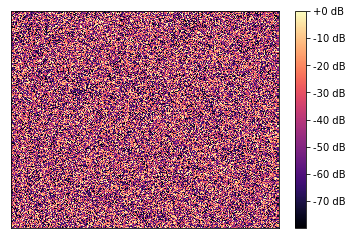

'backToSpectro = librosa.core.db_to_power(sUtils.unscaleSpectro(dreamNoiseSpectro, origSpectroSize, minAmp, maxAmp))\nbackToPhase = sUtils.unscaleSpectro(dreamNoisePhase, origSpectroSize, -math.pi, math.pi)\ninvStftNoiseDream = np.zeros(backToSpectro.shape, dtype=np.complex_)\nfor i in range(invStftNoiseDream.shape[0]):\n    for j in range(invStftNoiseDream.shape[1]):\n        invStftNoiseDream[i,j] = complex(backToSpectro[i,j]*math.cos(backToPhase[i,j]), backToSpectro[i,j]*math.sin(backToPhase[i,j]))\nn = len(x)\ny_hat = librosa.istft(invStftNoiseDream, length = n)\nipd.Audio(data=y_hat[start*sr:end*sr], rate=sr)'

In [21]:
backToSpectro = librosa.power_to_db(sUtils.unscaleSpectro(dreamNoiseSpectro, origSpectroSize, minAmp, maxAmp))
plt.figure()
librosa.display.specshow(backToSpectro)
plt.colorbar(format='%+2.0f dB')
plt.show()

'''backToSpectro = librosa.core.db_to_power(sUtils.unscaleSpectro(dreamNoiseSpectro, origSpectroSize, minAmp, maxAmp))
backToPhase = sUtils.unscaleSpectro(dreamNoisePhase, origSpectroSize, -math.pi, math.pi)
invStftNoiseDream = np.zeros(backToSpectro.shape, dtype=np.complex_)
for i in range(invStftNoiseDream.shape[0]):
    for j in range(invStftNoiseDream.shape[1]):
        invStftNoiseDream[i,j] = complex(backToSpectro[i,j]*math.cos(backToPhase[i,j]), backToSpectro[i,j]*math.sin(backToPhase[i,j]))
n = len(x)
y_hat = librosa.istft(invStftNoiseDream, length = n)
ipd.Audio(data=y_hat[start*sr:end*sr], rate=sr)'''

In [22]:
backToSpectro = librosa.core.db_to_power(backToSpectro)
'''backToPhase = sUtils.unscaleSpectro(dreamPhase, origSpectroSize, -math.pi, math.pi)
invStft = np.zeros(backToSpectro.shape, dtype=np.complex_)
for i in range(invStft.shape[0]):
    for j in range(invStft.shape[1]):
        invStft[i,j] = complex(backToSpectro[i,j]*math.cos(backToPhase[i,j]), backToSpectro[i,j]*math.sin(backToPhase[i,j]))'''
n = len(x)
y_hat = librosa.istft(backToSpectro*origPhase, length = n)
ipd.Audio(data=y_hat[start*sr:end*sr], rate=sr)

In [23]:
librosa.output.write_wav('dreamNoiseExample.wav', y_hat, sr)

## Control The Dream

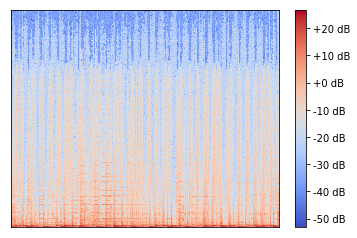

In [33]:
#spectroSize = 224
otherTrackId = 1482
'''otherSpectro, otherPhase, otherOrigSpectroSize = sUtils.loadSpectro(otherTrackId, spectroSize, minAmp, maxAmp)
otherSpectro = otherSpectro.data.numpy()'''
audioFilename = audioDirectory + "001/001482.mp3"
x, sr = librosa.load(audioFilename, sr=None, mono=True, duration = 10, offset = 0)

otherSpectro = librosa.core.stft(x)
origSpectroSize = spectro.shape
spectroSize = (512, 512)
otherScaledSpectro = librosa.power_to_db(np.abs(otherSpectro))

plt.figure()
librosa.display.specshow(otherScaledSpectro)
plt.colorbar(format='%+2.0f dB')
plt.show()


In [34]:
otherScaledSpectro = sUtils.scaleSpectro(otherScaledSpectro, spectroSize, minAmp, maxAmp)
#otherScaledPhase = sUtils.scaleSpectro(np.angle(otherSpectro), spectroSize, -math.pi, math.pi)

start, end = 0, 10
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

In [35]:
modelMag = resnet18(channel=1, num_classes=4).cuda()
checkpoint = torch.load('new_model/checkpoints/model_best.pth.tar')
modelMag.load_state_dict(checkpoint['state_dict'])
'''modelMag = models.__dict__['resnet18']()
modelMag = torch.nn.DataParallel(modelMag).cuda()
modelPhase = models.__dict__['resnet18']()
modelPhase = torch.nn.DataParallel(modelPhase).cuda()

checkpoint_path = 'resnet18/checkpoints/checkpoint_mag_512.pth.tar'
print("=> loading checkpoint '{}'".format(checkpoint_path))
checkpoint = torch.load(checkpoint_path)
start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
modelMag.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch: {}) (best_acc: {})"
        .format(checkpoint_path, checkpoint['epoch'], checkpoint['best_prec1']))

checkpoint_path = 'resnet18/checkpoints/checkpoint_phase_512.pth.tar'
print("=> loading checkpoint '{}'".format(checkpoint_path))
checkpoint = torch.load(checkpoint_path)
start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
modelPhase.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch: {}) (best_acc: {})"
        .format(checkpoint_path, checkpoint['epoch'], checkpoint['best_prec1']))'''

modelMag = nn.Sequential(*list(modelMag.children())[:-5])
#modelPhase = nn.Sequential(*list(modelPhase.children())[:-3])

1


In [36]:
otherScaledSpectro = torch.Tensor(np.expand_dims(np.expand_dims(otherScaledSpectro, 0),0).astype(np.float32)).cuda()
#otherScaledSpectro = torch.from_numpy(otherScaledSpectro).type(torch.DoubleTensor)
otherScaledSpectro = Variable(otherScaledSpectro)

#otherScaledPhase = torch.from_numpy(otherScaledPhase).type(torch.DoubleTensor)
#otherScaledPhase = Variable(otherScaledPhase).unsqueeze(0)

control_features_mag = modelMag.forward(otherScaledSpectro)
#control_features_phase = modelPhase.forward(otherScaledPhase)
control_features_mag = control_features_mag.cpu().data.numpy()
#control_features_phase = control_features_phase.data.numpy()

In [37]:
def objective_guide(dst, guide_features):
    x = dst.data[0].cpu().numpy().copy()
    #print ("guide_features", guide_features.shape)
    y = guide_features
    ch,w, h = x.shape
    #ch = 1
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    print ("shape of x", x.shape)
    print ("shape of y", y.shape)
    #A = x.T.dot(y) # compute the matrix of dot-products with guide features
    #A = torch.mm(torch.from_numpy(x.T).type(torch.DoubleTensor), torch.from_numpy(y).type(torch.DoubleTensor)).numpy()
    #A = np.zeros((x.shape[1],y.shape[1]))
    '''maxColumnIndices = []
    batchSize = 9000
    numBatches = x.shape[1]//batchSize
    for batchNum in range(numBatches):
        start = batchNum*batchSize
        end = start+batchSize
        if batchNum == numBatches-1:
            end = x.shape[1]
        #print ("x portion shape", (x[0,start:end].T).shape)
        #print ("y portion shape", (y).shape)
        prod = np.dot((x[0,start:end].T).reshape(-1,1), y)
        argMax = prod.argmax(1)
        for val in list(argMax):
            maxColumnIndices.append(val)
        del prod
    #print ("shape of A", A.shape)
    #result = y[:,A.argmax(1)] # select ones that match best
    #print ("shape of result", result.shape)
    result = y[:,maxColumnIndices]'''
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    result = y[:,A.argmax(1)] # select ones that match best
    print ("shape of result", result.shape)
    if torch.cuda.is_available():
        result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float)).cuda()
    else:
        result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float))
    return result

In [38]:
hopRockDreamSpectro = dream(modelMag, scaledSpectro, control=control_features_mag, distance=objective_guide, layerNumber=3)
print(hopRockDreamSpectro)

model after removing 5
(1, 1, 95, 95)
shape of x (64, 576)
shape of y (64, 16384)
shape of result (64, 576)
ratio 0.21424672
learning_rate_use 1.8670064113879583
imgBefore [[[[1.13009033e+02 1.79206009e+02 1.87001709e+02 ... 1.90255295e+02
    2.00859375e+02 1.94431335e+02]
   [1.10013672e+02 1.84448318e+02 1.88003281e+02 ... 2.05276642e+02
    2.04743423e+02 1.95369156e+02]
   [1.01877464e+02 1.81022507e+02 1.92835587e+02 ... 1.99955383e+02
    2.07256317e+02 2.04103943e+02]
   ...
   [2.54672432e+01 5.92848511e+01 5.72141380e+01 ... 5.88885803e+01
    6.04406853e+01 1.23858276e+02]
   [2.13444424e+01 5.84906693e+01 5.73489151e+01 ... 5.76176987e+01
    5.96353302e+01 1.23601212e+02]
   [5.31695746e-02 5.90108147e+01 5.95216904e+01 ... 5.66953430e+01
    5.78508835e+01 1.23656731e+02]]]]
imgAfter (1, 1, 95, 95)
shape of x (64, 576)
shape of y (64, 16384)
shape of result (64, 576)
ratio 0.20737648
learning_rate_use 1.9288590480570247
imgBefore [[[[112.48088    178.60715    186.36745   

/home/iaakhter/.conda/envs/mypy35/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


shape of result (64, 576)
ratio 0.21529834
learning_rate_use 1.8578870627231603
imgBefore [[[[1.12793427e+02 1.78451889e+02 1.85831100e+02 ... 1.92486115e+02
    2.01117218e+02 1.94229218e+02]
   [1.09755936e+02 1.82701599e+02 1.88318344e+02 ... 2.07283768e+02
    2.04783432e+02 1.93968994e+02]
   [1.00617722e+02 1.80647675e+02 1.93490936e+02 ... 2.01405365e+02
    2.07894943e+02 2.02190125e+02]
   ...
   [2.56856022e+01 5.83654213e+01 5.78956337e+01 ... 5.93288345e+01
    6.02629623e+01 1.23627838e+02]
   [2.11549625e+01 5.77056732e+01 5.67379494e+01 ... 5.73974571e+01
    5.95473213e+01 1.24210915e+02]
   [3.56827527e-02 5.80993118e+01 5.90005341e+01 ... 5.69286919e+01
    5.89587059e+01 1.24067902e+02]]]]
imgAfter (1, 1, 95, 95)
shape of x (64, 576)
shape of y (64, 16384)
shape of result (64, 576)
ratio 0.202933
learning_rate_use 1.9710939220417838
imgBefore [[[[112.39979    178.15425    185.04546    ... 193.1476
    201.44269    193.94995   ]
   [109.625496   182.32635    188.21535

shape of result (64, 576)
ratio 0.17772038
learning_rate_use 2.2507266396587196
imgBefore [[[[111.33606    177.35318    182.63614    ... 193.79108
    204.26292    194.11316   ]
   [103.066925   178.37419    187.87582    ... 215.92491
    211.71184    191.5413    ]
   [ 92.024086   178.63005    198.88416    ... 208.11401
    212.0241     194.48947   ]
   ...
   [ 28.780424    57.909725    59.67601    ...  61.040287
     62.483227   126.9989    ]
   [ 20.59621     54.245937    58.1636     ...  54.402416
     61.06686    125.44214   ]
   [ -0.42683443  53.66234     58.859875   ...  52.113335
     60.546616   123.927704  ]]]]
imgAfter (1, 1, 95, 95)
shape of x (64, 576)
shape of y (64, 16384)
shape of result (64, 576)
ratio 0.17553078
learning_rate_use 2.278802659259329
imgBefore [[[[1.11693871e+02 1.77637024e+02 1.83061157e+02 ... 1.93460266e+02
    2.04515106e+02 1.94125183e+02]
   [1.03379295e+02 1.78478378e+02 1.88361923e+02 ... 2.15522690e+02
    2.11483170e+02 1.91896164e+02]
   [9.

shape of result (64, 1156)
ratio 0.19156282
learning_rate_use 2.0880879040458984
imgBefore [[[[107.783775  171.73022   176.50865   ... 195.26244   217.1794
    194.95668  ]
   [102.88921   181.54118   186.14922   ... 222.80806   213.54227
    183.81168  ]
   [102.91201   168.21683   183.78046   ... 210.57414   211.89339
    198.77708  ]
   ...
   [ 25.364754   56.94231    58.14491   ...  60.482944   65.59566
    128.21327  ]
   [ 21.259745   54.039917   57.439243  ...  55.710304   57.48323
    125.75782  ]
   [ -0.5385772  52.243645   53.901287  ...  53.08395    60.707684
    126.86748  ]]]]
imgAfter (1, 1, 133, 133)
shape of x (64, 1156)
shape of y (64, 16384)
shape of result (64, 1156)
ratio 0.17922679
learning_rate_use 2.231809257725455
imgBefore [[[[106.86562   171.62947   175.78398   ... 194.81938   217.90585
    194.47252  ]
   [103.670654  182.32124   186.76773   ... 223.58588   213.86884
    183.77344  ]
   [103.077324  168.41154   183.31512   ... 211.06294   212.10783
    197.

ratio 0.19707437
learning_rate_use 2.0296906332849343
imgBefore [[[[105.19458   168.12137   174.94421   ... 221.8278    218.09692
    193.53209  ]
   [104.70159   176.40709   175.15724   ... 234.20755   207.54608
    173.50462  ]
   [ 92.146736  190.12512   188.64114   ... 231.55597   209.99611
    189.5399   ]
   ...
   [ 32.63715    58.45373    60.53019   ...  60.23858    58.484474
    126.70163  ]
   [ 16.38047    50.66077    56.04046   ...  54.21337    56.32327
    125.61995  ]
   [ -0.3095369  51.310345   52.313244  ...  48.116135   63.713955
    124.209366 ]]]]
imgAfter (1, 1, 186, 186)
shape of x (64, 2209)
shape of y (64, 16384)
shape of result (64, 2209)
ratio 0.19182657
learning_rate_use 2.085216902660965
imgBefore [[[[1.0536041e+02 1.6803168e+02 1.7546867e+02 ... 2.2259865e+02
    2.1956670e+02 1.9373120e+02]
   [1.0452806e+02 1.7564259e+02 1.7531622e+02 ... 2.3503098e+02
    2.0790723e+02 1.7285219e+02]
   [9.1697426e+01 1.8976071e+02 1.8931996e+02 ... 2.3212671e+02
    2.0

shape of result (64, 2209)
ratio 0.17548558
learning_rate_use 2.2793895507359574
imgBefore [[[[102.16465   159.59662   177.11449   ... 227.1451    222.26436
    192.00333  ]
   [101.294495  178.46799   185.5295    ... 241.82216   210.8726
    172.38007  ]
   [ 91.37424   193.42654   194.39352   ... 232.56482   204.4907
    182.24744  ]
   ...
   [ 37.43962    60.93384    63.07983   ...  62.961155   61.518616
    130.70273  ]
   [ 15.602723   49.58184    55.160103  ...  53.87445    56.751945
    129.65044  ]
   [  1.1676264  46.49081    51.394974  ...  47.64413    67.07623
    127.7445   ]]]]
imgAfter (1, 1, 186, 186)
shape of x (64, 2209)
shape of y (64, 16384)
shape of result (64, 2209)
ratio 0.18463326
learning_rate_use 2.166456958089276
imgBefore [[[[101.77115   159.97269   177.78947   ... 226.8215    223.0147
    192.1928   ]
   [101.101105  178.76193   186.20392   ... 240.88596   211.25755
    172.4453   ]
   [ 91.70299   194.44861   194.50714   ... 231.92867   204.62924
    182.6

ratio 0.18235381
learning_rate_use 2.1935379422543244
imgBefore [[[[ 97.777016   151.64676    162.30591    ... 226.9004
    215.16869    189.1086    ]
   [ 96.99087    161.71481    174.20967    ... 210.02544
    191.48344    155.98425   ]
   [ 93.178894   193.9101     186.84747    ... 225.87483
    207.12132    176.13957   ]
   ...
   [ 32.497906    60.363144    58.86171    ...  62.45877
     60.64489    131.3661    ]
   [  9.47802     52.313972    46.575745   ...  57.929993
     62.96009    131.50961   ]
   [  0.85595596  50.336143    47.368988   ...  68.885605
     66.47096    128.85234   ]]]]
imgAfter (1, 1, 261, 261)
shape of x (64, 4356)
shape of y (64, 16384)
shape of result (64, 4356)
ratio 0.18467405
learning_rate_use 2.165978330490123
imgBefore [[[[ 97.2827    151.77724   162.7035    ... 227.33276   215.746
    189.48683  ]
   [ 95.88813   160.47316   174.45424   ... 209.77829   191.05783
    155.57394  ]
   [ 92.61555   193.23207   186.6409    ... 225.80392   206.89252
    17

shape of result (64, 8464)
ratio 0.19247517
learning_rate_use 2.07819013857158
imgBefore [[[[ 93.29608  145.02052  150.74335  ... 227.56094  213.1865
    189.67235 ]
   [ 87.86889  141.71167  156.2872   ... 196.88715  173.66484
    160.23322 ]
   [ 99.44926  175.83952  184.64694  ... 213.70389  190.35443
    134.20284 ]
   ...
   [  7.308944  53.727024  62.23621  ...  63.134357  67.67148
    135.5543  ]
   [ 14.362814  47.46127   54.43568  ...  60.787914  69.97967
    135.17276 ]
   [  1.768096  53.779007  41.473103 ...  74.00921   65.87534
    134.37666 ]]]]
imgAfter (1, 1, 366, 366)
shape of x (64, 8464)
shape of y (64, 16384)
shape of result (64, 8464)
ratio 0.18278624
learning_rate_use 2.18834851809107
imgBefore [[[[ 93.46042   144.04333   150.10672   ... 227.15355   214.31763
    190.73996  ]
   [ 87.47422   140.81314   156.02658   ... 196.59134   173.51553
    159.80392  ]
   [ 99.22218   175.86697   185.05777   ... 213.5373    189.80226
    133.50156  ]
   ...
   [  6.286414   5

shape of result (64, 8464)
ratio 0.1780547
learning_rate_use 2.2465005876199857
imgBefore [[[[ 91.198135  142.09637   150.30286   ... 229.79312   216.75487
    192.03125  ]
   [ 82.98014   136.67035   157.11261   ... 193.46867   169.72115
    154.07071  ]
   [ 97.872345  173.06425   185.08755   ... 210.4437    186.08177
    128.87444  ]
   ...
   [ 11.372994   54.923893   67.12499   ...  68.43348    72.19771
    139.22421  ]
   [ 17.588655   48.285316   59.034035  ...  66.77262    76.33815
    141.40974  ]
   [  4.5163746  52.81573    42.977295  ...  79.264175   73.13983
    139.78325  ]]]]
imgAfter (1, 1, 366, 366)
shape of x (64, 8464)
shape of y (64, 16384)
shape of result (64, 8464)
ratio 0.1750925
learning_rate_use 2.284506715979622
imgBefore [[[[ 91.18644   141.8795    150.9162    ... 229.32533   217.36906
    193.00969  ]
   [ 82.77723   137.18312   157.33371   ... 194.10599   170.29402
    154.3953   ]
   [ 97.825806  173.3739    185.15912   ... 211.00713   187.03029
    128.43

shape of y (64, 16384)
shape of result (64, 16384)
ratio 0.17957681
learning_rate_use 2.227459050537391
imgBefore [[[[ 88.46222  136.9454   150.81902  ... 225.27614  213.30872
    195.6967  ]
   [ 76.33205  130.51825  123.775345 ... 185.72682  152.6686
    158.28079 ]
   [ 91.682465 150.57834  161.39166  ... 183.658    172.77301
    148.74223 ]
   ...
   [ 27.521627  37.187096  72.148094 ...  71.009636  77.78108
    147.1405  ]
   [ 19.961664  62.94002   41.543995 ...  78.128876  86.09154
    147.75616 ]
   [  8.19779   60.672894  49.430138 ...  84.27293   71.528175
    147.4536  ]]]]
imgAfter (1, 1, 512, 512)
shape of x (64, 16384)
shape of y (64, 16384)
shape of result (64, 16384)
ratio 0.18315832
learning_rate_use 2.183902937522836
imgBefore [[[[ 88.60166  136.69191  150.17674  ... 225.70035  213.53955
    196.64415 ]
   [ 75.462395 129.15723  123.66289  ... 185.4199   152.52638
    157.92986 ]
   [ 91.09129  149.97528  162.26859  ... 183.43977  172.47913
    147.53072 ]
   ...
   [

In [39]:
#hopRockDreamPhase = dream(modelPhase, scaledPhase, control=control_features_phase, distance=objective_guide, layerNumber=3)
#print(hopRockDreamPhase)

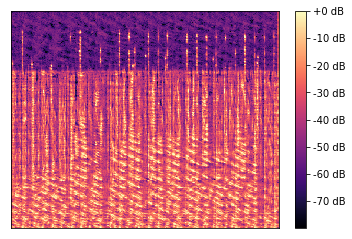

In [40]:
'''hopRockDreamSpectro = hopRockDreamSpectro[0,:]
#Convert it back to 
backToSpectro = sUtils.unscaleSpectro(hopRockDreamSpectro, origSpectroSize, minAmp, maxAmp)
# Multiply power spectrogram with phase to get original complex spectrogram
backToSpectro = backToSpectro*phase

# Revert complex spectrogram to audio
n = len(x)
y_hat = librosa.istft(backToSpectro, length = n)
ipd.Audio(data=y_hat[start*sr:end*sr], rate=sr)'''
hopRockDreamSpectro = hopRockDreamSpectro[0,0,:]
#hopRockDreamPhase = hopRockDreamPhase[0,:]

backToSpectro = librosa.power_to_db(sUtils.unscaleSpectro(hopRockDreamSpectro, origSpectroSize, minAmp, maxAmp))
#backToPhase = sUtils.unscaleSpectro(hopRockDreamPhase, origSpectroSize, -math.pi, math.pi)

plt.figure()
librosa.display.specshow(backToSpectro)
plt.colorbar(format='%+2.0f dB')
plt.show()


In [41]:
backToSpectro = librosa.core.db_to_power(backToSpectro)
#backToPhase = sUtils.unscaleSpectro(hopRockDreamPhase, origSpectroSize, -math.pi, math.pi)
'''invStft = np.zeros(backToSpectro.shape, dtype=np.complex_)
for i in range(invStft.shape[0]):
    for j in range(invStft.shape[1]):
        invStft[i,j] = complex(backToSpectro[i,j]*math.cos(backToPhase[i,j]), backToSpectro[i,j]*math.sin(backToPhase[i,j]))'''
n = len(x)
y_hat = librosa.istft(backToSpectro*origPhase, length = n)
ipd.Audio(data=y_hat[start*sr:end*sr], rate=sr)

In [42]:
librosa.output.write_wav('dreamExampleControl.wav', y_hat, sr)